# Udacity PyTorch Challenge (recreating fastai components from scratch)
The [source](https://gist.github.com/joshfp/9161a970feb01d2c9672539dc048290a) of this notebook is joshfp again, amazing! 

In [1]:
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

import os
import matplotlib.pyplot as plt
import PIL.Image as Image
from datetime import datetime, timedelta
from collections import Iterable
import numpy as np
from pathlib import Path

## 1. Data

### 1.1. Load data

In [3]:
data_dir = Path('~/datasets/flower_data/').expanduser()
train_dir = data_dir/'train'
valid_dir = data_dir/'valid'

In [4]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

def get_transforms(img_sz):
    train_tfms = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(0.2, 0.2),
        transforms.RandomResizedCrop(img_sz, scale=(0.9,1.), ratio=(1.,1.)),
        transforms.ToTensor(),
        transforms.Normalize(*imagenet_stats)])
    valid_tfms = transforms.Compose([
        transforms.Resize(img_sz),
        transforms.CenterCrop(img_sz),
        transforms.ToTensor(),
        transforms.Normalize(*imagenet_stats)])  
    return (train_tfms, valid_tfms)
    

class DataBunch():
    def __init__(self, tfms, bs):
        self.train_ds = ImageFolder(train_dir, tfms[0])
        self.valid_ds = ImageFolder(valid_dir, tfms[1])
        self.train_dl = DataLoader(self.train_ds, bs, shuffle=True, num_workers=os.cpu_count())
        self.valid_dl = DataLoader(self.valid_ds, bs*2, shuffle=False)
        self.c = len(self.train_ds.classes)

In [5]:
data = DataBunch(get_transforms(299), 32)

### 1.2. Visualize data

In [6]:
def show(img, figsize=(8,8)):
    fig = plt.figure(figsize=figsize)
    plt.imshow(img.numpy().transpose(1,2,0))

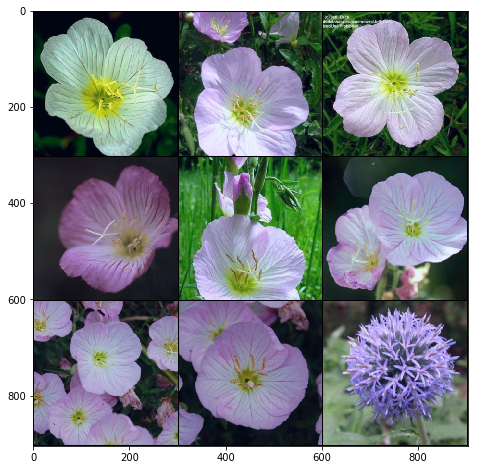

In [7]:
x,_ = next(iter(data.valid_dl))
grid = make_grid(x[:9], nrow=3, normalize=True)
show(grid)

### 1.3. Visualize data augmentation

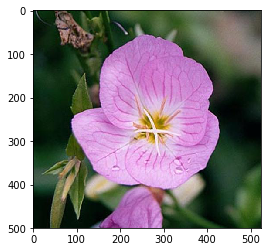

In [8]:
img_fn = train_dir/'1/image_06734.jpg'
img = Image.open(img_fn)
plt.imshow(img);

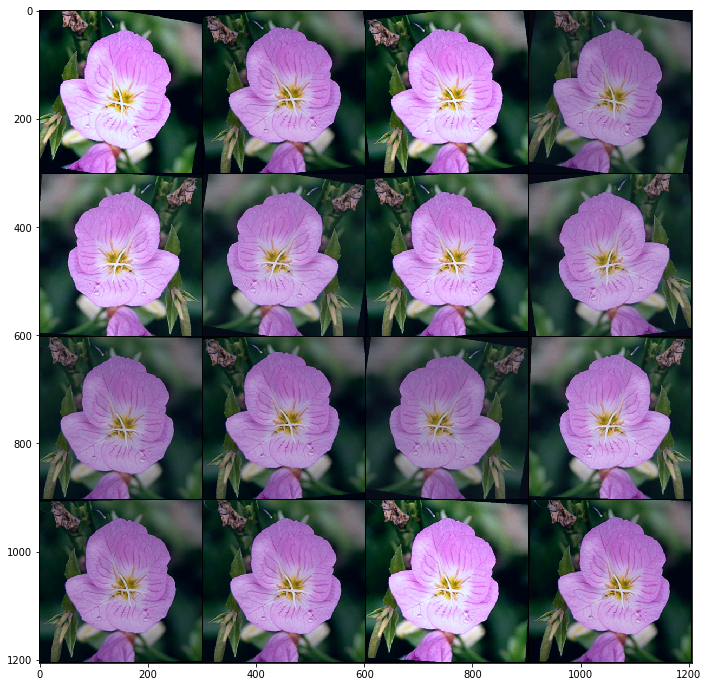

In [9]:
tfms = data.train_ds.transform
img_aug = torch.stack([tfms(img) for _ in range(16)])
show(make_grid(img_aug, nrow=4, normalize=True), figsize=(12,12))

## 2. Recreating fastai components

### 2.1. Model (Resnet)

In [10]:
class AdaptiveConcatPool2d(nn.Module):
    def __init__(self):
        super().__init__()
        self.avg, self.max = nn.AdaptiveAvgPool2d(1), nn.AdaptiveMaxPool2d(1)
    def forward(self, x): return torch.cat([self.avg(x), self.max(x)], dim=1) 
    
class Flatten(nn.Module):
    def __init__(self): super().__init__()
    def forward(self, x): return x.view(x.size(0), -1)

flatten_model = lambda m: sum(map(flatten_model, list(m.children())), []) if len(list(m.children())) else [m]

In [11]:
def create_resnet(n_resnet, n_classes):
    assert n_resnet in [18, 34, 50, 101, 152], 'n_resnet must be: 18, 34, 50, 101 or 152.'
    import torchvision.models
    arch = getattr(torchvision.models, 'resnet'+str(n_resnet))
    body = arch(pretrained=True)
    body = nn.Sequential(*list(body.children())[:-2])
    cnn_out_sz = 1024 if n_resnet in [18, 34] else 4096
    head = nn.Sequential(AdaptiveConcatPool2d(),
                         Flatten(),
                         nn.BatchNorm1d(cnn_out_sz),
                         nn.Dropout(0.25),
                         nn.Linear(cnn_out_sz, 512),
                         nn.ReLU(),
                         nn.BatchNorm1d(512),
                         nn.Dropout(0.5),
                         nn.Linear(512, n_classes),
                         nn.LogSoftmax(dim=1))
    for l in head:
        if not isinstance(l, (nn.BatchNorm1d, nn.BatchNorm2d)):
            if hasattr(l, 'weight'): nn.init.kaiming_normal_(l.weight.data)
            if hasattr(l, 'bias'): l.bias.data.zero_()
    
    model = nn.Sequential(body, head)
    layer_groups = [nn.Sequential(*flatten_model(model[0][:6])),
                    nn.Sequential(*flatten_model(model[0][6:])),
                    nn.Sequential(*flatten_model(model[1]))]
    return model, layer_groups

## 2.2. Learner

In [12]:
class Learner():
    def __init__(self, model, data, opt_func, loss_func, path='.', layer_groups=None):
        self.device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
        self.model = model.to(self.device)
        self.data = data
        self.opt_func = opt_func
        self.loss_func = loss_func  
        self.path = path
        if layer_groups is not None:
            self.layer_groups = layer_groups
        else: 
            self.layer_groups = [nn.Sequential(*flatten_model(self.model))]
        self.freeze()
    
    def fit_one_cycle(self, n_epochs, lr=3e-3, wd=1e-2):
        opt = self._create_opt(lr, wd)
        opt_sched = OneCycleSched(opt, cycle_len=len(self.data.train_dl)*n_epochs)
        print(f'epoch  train_loss  valid_loss  valid_acc')
        for epoch in range(n_epochs):
            train_loss = valid_loss = valid_acc = 0.
            start = datetime.now()
            self.model.train()
            for x,y in self.data.train_dl:
                x,y = x.to(self.device), y.to(self.device)
                output = self.model(x)
                loss = self.loss_func(output, y)
                loss.backward()
                opt_sched.step()
                opt.step()
                opt.zero_grad()    
                train_loss += loss.item() * len(x)
            self.model.eval()
            for x,y in self.data.valid_dl:
                x,y = x.to(self.device), y.to(self.device)
                with torch.no_grad(): output = self.model(x)
                loss = self.loss_func(output, y)
                pred = output.argmax(dim=1)
                valid_loss += loss.item() * len(x)
                valid_acc += (pred==y).sum().item()
            train_loss /= len(self.data.train_ds)
            valid_loss /= len(self.data.valid_ds)
            valid_acc /= len(self.data.valid_ds)
            elapsed = datetime.now() - start
            print(f'{epoch+1:<7}{train_loss:<12.6f}{valid_loss:<12.6f}' +
                  f'{valid_acc:<12.6f}({elapsed.seconds} seg.)')
            
    def freeze(self):
        for lg in self.layer_groups:
            is_last_lg = lg==self.layer_groups[-1]
            for l in lg:
                if not isinstance(l, (nn.BatchNorm1d, nn.BatchNorm2d)):
                    for p in l.parameters(): p.requires_grad_(is_last_lg)
                else:
                    for p in l.parameters(): p.requires_grad_(True)

    def unfreeze(self):
        for lg in self.layer_groups:
            for p in lg.parameters(): p.requires_grad_(True)
                 
    def _create_opt(self, lrs, wd):
        if isinstance(lrs, Iterable):
            assert len(self.layer_groups) == len(lrs), \
                "Lenght of 'lrs' should be 1 or match the number of layer groups."
        else:
            lrs = [lrs] * len(self.layer_groups)
        params = [{'params':l.parameters(), 'lr': lr} for l,lr in zip(layer_groups, lrs)]
        return self.opt_func(params, weight_decay=wd)
            
    def save(self, name):
        obj = {
            'model_state_dict': self.model.state_dict()
        }
        os.makedirs(self.path + '/model', exist_ok=True)
        torch.save(obj, self.path+'/model/'+ name)
        
    def load(self, name):
        obj = torch.load(self.path+'/model/'+ name)
        self.model.load_state_dict(obj['model_state_dict'])
        
    def lr_find(self, lr_start=1e-7, lr_end=10., num_it=100):
        opt = self._create_opt(lr_start, 1e-2)
        gamma = (lr_end/lr_start) ** (1/num_it)
        opt_sched = optim.lr_scheduler.ExponentialLR(opt, gamma)
        mov_avg, smooth_loss, n = 0., 0., 0
        best_loss = float('inf')
        self.recorder = {'loss': [], 'lr': []}
        self.save('tmp')
        while True:
            for x,y in self.data.train_dl:
                x,y = x.to(self.device), y.to(self.device)
                output = self.model(x)
                loss = self.loss_func(output, y)
                loss.backward()
                opt_sched.step()
                opt.step()
                opt.zero_grad()
                n += 1
                mov_avg = 0.98 * mov_avg + 0.02 * loss.item()
                smooth_loss = mov_avg / (1 - 0.98 ** n) 
                self.recorder['lr'].append(opt.state_dict()['param_groups'][-1]['lr'])
                self.recorder['loss'].append(smooth_loss)
                if smooth_loss < best_loss:
                    best_loss = smooth_loss
                if (n == num_it) or smooth_loss > best_loss * 4:
                    self.load('tmp')
                    print('LR find completed!')
                    return
    def plot_lr(self, skip_start=5, skip_end=5):
        lr = self.recorder['lr'][skip_start:-skip_end]
        loss = self.recorder['loss'][skip_start:-skip_end]
        plt.semilogx(lr, loss)
        plt.xlabel('Learning Rate')   
        plt.ylabel('Loss')
        
    def predict(self, dl):
        self.model.eval()
        preds, ys = [], []
        for x,y in dl:
            x = x.to(self.device)
            with torch.no_grad: output = self.model(x)
            preds.append(output.cpu())
            ys.append(y)
        return torch.cat(preds).argmax(dim=1), torch.cat(ys)

## 2.3. Optimizer

#### AdamW

In [13]:
class AdamW(optim.Adam):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.99), eps=1e-08, 
                 weight_decay=0, amsgrad=False):
        super().__init__(params, lr, betas, eps, 0., amsgrad)
        for group in self.param_groups: group['weight_decay'] = 0.
        self.wd = weight_decay
        
    def step(self):
        for group in self.param_groups:
            for param in group['params']:
                    if param.requires_grad: param.data.mul_(1 - self.wd * group['lr'])
        super().step()

#### One-Cycle Policy

In [14]:
def annealing_linear(start, end, pct): return start + pct * (end-start)
def annealing_cosine(start, end, pct): 
    cos_out = (np.cos(np.pi * pct) + 1) / 2
    return end + (start-end) * cos_out    

class OneCycleSched():
    def __init__(self, optimizer, cycle_len, div_factor=25., pct_start=0.3, mom_range=(0.95, 0.85)):
        assert isinstance(optimizer, (optim.Adam, AdamW)), \
            'By the time being only Adam & AdamW are supported.'
        self.optimizer = optimizer
        self.lrs_range = [(group['lr'], group['lr']/div_factor) for group in optimizer.param_groups]
        self.cycle_len = cycle_len - 1
        self.split_epoch = int(cycle_len * pct_start)
        self.moms_range = mom_range
        self.step(0)
        self.last_epoch = -1

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
        self.last_epoch = epoch
        mom = self.get_mom()
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr
            param_group['betas'] = (mom, param_group['betas'][1])
        
    def get_lr(self):
        if self.last_epoch <= self.split_epoch:
            pct = self.last_epoch / self.split_epoch
            return [annealing_linear(min_lr, max_lr, pct)
                for max_lr, min_lr in self.lrs_range]
        else:
            pct = (self.split_epoch-self.last_epoch) / (self.split_epoch-self.cycle_len)
            return [annealing_cosine(max_lr, min_lr*1e-4, pct)
                for max_lr, min_lr in self.lrs_range]
        
    def get_mom(self):
        max_mom,min_mom = self.moms_range
        if self.last_epoch <= self.split_epoch:
            pct =  self.last_epoch / self.split_epoch
            return annealing_linear(max_mom, min_mom, pct)
        else:
            pct = (self.split_epoch-self.last_epoch) / (self.split_epoch-self.cycle_len)
            return annealing_cosine(min_mom, max_mom, pct)

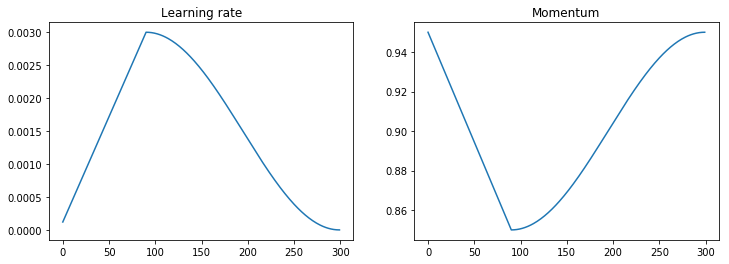

In [15]:
epochs = 3
n_batches = 100 # len(train_dl)
cycle_len = epochs*n_batches
opt = optim.Adam(nn.Linear(10,10).parameters(), 3e-3)
sched = OneCycleSched(opt, cycle_len)
rec_lrs = []
rec_moms = []
for i in range(cycle_len):
    sched.step()
    rec_lrs.append(opt.state_dict()['param_groups'][0]['lr'])
    rec_moms.append(opt.state_dict()['param_groups'][0]['betas'][0])
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].plot(rec_lrs)
ax[0].set_title('Learning rate')
ax[1].plot(rec_moms)
ax[1].set_title('Momentum')
fig.show()

## 3. Training!

In [16]:
model, layer_groups = create_resnet(50, data.c)
learner = Learner(model, data, AdamW, nn.NLLLoss(), layer_groups=layer_groups)

In [17]:
learner.lr_find()

LR find completed!


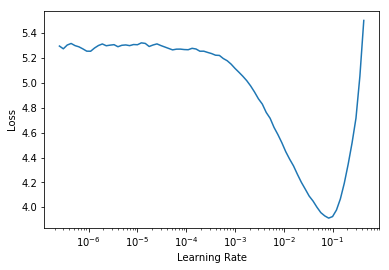

In [18]:
learner.plot_lr()

In [19]:
learner.fit_one_cycle(4, 3e-3)

epoch  train_loss  valid_loss  valid_acc
1      1.953195    0.350143    0.919315    (57 seg.)
2      0.413114    0.256842    0.929095    (58 seg.)
3      0.175667    0.116963    0.973105    (58 seg.)
4      0.062491    0.098184    0.974328    (58 seg.)


In [ ]:
learner.save('299-stage-1')

In [22]:
learner.load('299-stage-1')
learner.unfreeze()
learner.fit_one_cycle(4, lr=(1e-6, 1e-5, 1e-4), wd=1e-1)

epoch  train_loss  valid_loss  valid_acc
1      0.033992    0.091933    0.976773    (77 seg.)
2      0.032487    0.083748    0.975550    (77 seg.)
3      0.026953    0.077142    0.981663    (77 seg.)
4      0.016151    0.079515    0.981663    (77 seg.)


In [23]:
learner.save('224-stage-2')